# Food Vision using transfer learning | trying to beat [DeepFood](https://https://arxiv.org/abs/1606.05675) paper

* Guided by 

In [1]:
# Check Nvidia Version
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-8be66c5b-eb41-aa19-af3b-b7b82dbeee78)


In [2]:
# Import TensorFlow
import tensorflow as tf

# Downgrade tensorflow because im having trouble saving it 
# If you are using Google Colab restart runtime 
#pip install tensorflow-gpu==2.9.1

In [3]:
# Check version if 2.10
print(tf.__version__)

2.9.1


In [4]:
# Get Helper Functions
!wget https://raw.githubusercontent.com/Peebs-Tech/TensorFlow---repo/main/tensorflow_functions.py

--2023-04-10 12:22:54--  https://raw.githubusercontent.com/Peebs-Tech/TensorFlow---repo/main/tensorflow_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9644 (9.4K) [text/plain]
Saving to: ‘tensorflow_functions.py.1’

tensorflow_function 100%[===================>]   9.42K  --.-KB/s    in 0s      

2023-04-10 12:22:54 (100 MB/s) - ‘tensorflow_functions.py.1’ saved [9644/9644]



In [5]:
# Import functions
from tensorflow_functions import peebs_tensorboard_callbacks, peebs_plot_loss_curves, peebs_compare_historys

In [6]:
# Get TensorFlow datasets
import tensorflow_datasets as tfds

In [7]:
# Find food101
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [8]:
# Load the data
(train_data, test_data), ds_info = tfds.load(name = "food101",
                                             split = ["train", "validation"],
                                             shuffle_files = True,
                                             as_supervised = True,
                                             with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteCFOEYI/food101-train.tfrecord*...:   0%|          …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteCFOEYI/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [9]:
# Features of Food101 tfds
# We can get the class names from tfds because of the as_supervised = True which downloads the data in tupple format
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [10]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Visualize dataset

In [11]:
# Get one sample from the training data
one_sample  = train_data.take(1)
one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [12]:
# Output info about our training sample
for image, label in one_sample:
  print(f"""
  Image shape : {image.shape})
  Image dtype : {image.dtype}
  Target class from Food101 (tensor form) : {label}
  Class name (str format) : {class_names[label.numpy()]}
  """)


  Image shape : (512, 512, 3))
  Image dtype : <dtype: 'uint8'>
  Target class from Food101 (tensor form) : 75
  Class name (str format) : pho
  


* The dataset have different Image shape

In [13]:
# What does one image tensor looks like from tfds
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 48,  51,  30],
        [ 49,  52,  31],
        [ 50,  55,  33],
        ...,
        [ 93, 120,  77],
        [ 87, 112,  70],
        [ 80, 105,  63]],

       [[ 43,  46,  25],
        [ 46,  49,  28],
        [ 49,  54,  32],
        ...,
        [ 95, 122,  77],
        [ 90, 117,  72],
        [ 83, 110,  65]],

       [[ 40,  43,  22],
        [ 45,  48,  27],
        [ 50,  55,  33],
        ...,
        [ 90, 119,  71],
        [ 87, 116,  68],
        [ 84, 113,  65]],

       ...,

       [[ 48,  55,  37],
        [ 48,  55,  37],
        [ 41,  50,  33],
        ...,
        [ 32,  43,  35],
        [ 25,  36,  30],
        [ 21,  32,  26]],

       [[ 42,  47,  27],
        [ 38,  46,  25],
        [ 34,  43,  26],
        ...,
        [ 38,  49,  41],
        [ 33,  44,  38],
        [ 29,  40,  34]],

       [[ 37,  42,  20],
        [ 32,  40,  19],
        [ 31,  38,  20],
        ...,
        [ 33,  44,  3

In [14]:
# Min & Max values
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

* Our image tensorf have values between 0 and 255 (standard red, green, blue) and is in uint8 dtype, I need float32 dtype

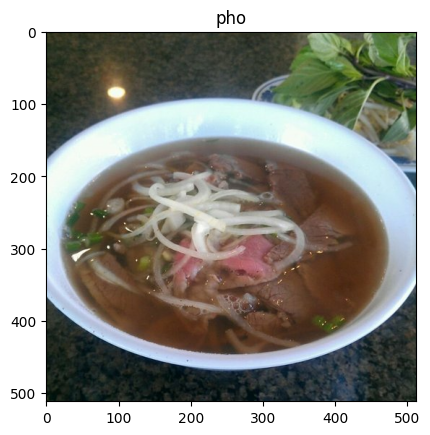

In [15]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis = False

## Preprocess the Data

In [16]:
# Preprocess function 
# Thinking of adding this to my helper_functions
def preprocess_img (image, label, img_shape = 224):
  """
  Converts image datatype from 'uint8' to 'float32' and reshapes image to 
  [img_shape, img_shape, color_channels]
  """

  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label

In [17]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing: \n {image[:2]}..., \nShape: {image.shape}, \nDataType: {image.dtype}\n")
print(f"Image after preprocessing: \n {preprocessed_img[:2]}..., \nShape: {preprocessed_img.shape}, \nDataType: {preprocessed_img.dtype}\n")

Image before preprocessing: 
 [[[ 48  51  30]
  [ 49  52  31]
  [ 50  55  33]
  ...
  [ 93 120  77]
  [ 87 112  70]
  [ 80 105  63]]

 [[ 43  46  25]
  [ 46  49  28]
  [ 49  54  32]
  ...
  [ 95 122  77]
  [ 90 117  72]
  [ 83 110  65]]]..., 
Shape: (512, 512, 3), 
DataType: <dtype: 'uint8'>

Image after preprocessing: 
 [[[ 46.2551    49.2551    28.255102]
  [ 49.954082  54.954082  32.954082]
  [ 42.494896  50.494896  27.494898]
  ...
  [ 97.50995  129.86195   81.4385  ]
  [ 94.02041  122.21427   77.33163 ]
  [ 86.42833  112.71404   68.78547 ]]

 [[ 45.336735  48.336735  27.336735]
  [ 53.714287  58.714287  36.714287]
  [ 40.44388   48.44388   25.443878]
  ...
  [ 92.948906 128.3213    74.52029 ]
  [ 85.48981  117.27552   67.41838 ]
  [ 90.70417  122.48989   72.632744]]]..., 
Shape: (224, 224, 3), 
DataType: <dtype: 'float32'>



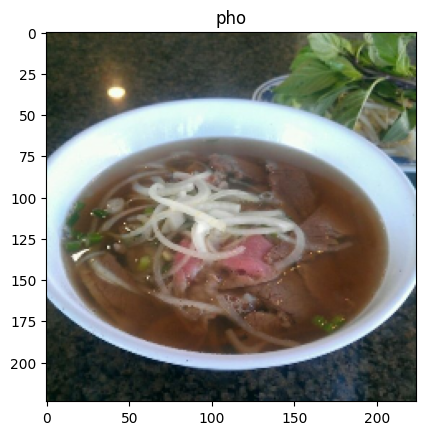

In [18]:
# Plot preprocessed image
plt.imshow(preprocessed_img/255)
plt.title(class_names[label])
plt.axis = False

## Batch and prepare datasets
- for memory efficiency

In [19]:
# Map preprocessing function to training data (and parallelize)
train_data = train_data.map(map_func = preprocess_img, num_parallel_calls = tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size = 1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(map_func = preprocess_img, num_parallel_calls = tf.data.AUTOTUNE)
# Turn test_data into batches (dont shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [20]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Modelling callbacks

In [21]:
# Tensorboard Callbacks
from tensorflow_functions import peebs_tensorboard_callbacks

# ModelCheckpoint Callbacks
checkpoint_path = "model_checkpoints/cp.ckpt" # savings weights need cktp extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor = "val_accuracy",
                                                      save_best_only = True,
                                                      save_weights_only = True,
                                                      verbose = 0)

In [22]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("float32")

In [23]:
mixed_precision.global_policy()

<Policy "float32">

## Build the model

In [24]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB4(include_top = False) # Download without top layers
base_model.trainable = False # Freeze base model layers

# Create a fuctional model
inputs = layers.Input(shape = input_shape, name = "input_layer")
x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D(name = "pooling_layer")(x)
x = layers.Dense(len(class_names))(x)

# Separate the activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name = "softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

71686520/71686520 [==============================] - 0s 0us/step


In [25]:
# Check model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, None, None, 1792)  17673823 
                                                                 
 pooling_layer (GlobalAverag  (None, 1792)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               181093    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 17,854,916
Trainable params: 181,093
Non-traina

In [26]:
# Check dtype_policy atrributes in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb4 False float32 <Policy "float32">
pooling_layer True float32 <Policy "float32">
dense True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">


In [27]:
# Check layers in the base model and see dtype policy
for layer in model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "float32">
normalization False float32 <Policy "float32">
tf.math.truediv False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "float32">
stem_conv False float32 <Policy "float32">
stem_bn False float32 <Policy "float32">
stem_activation False float32 <Policy "float32">
block1a_dwconv False float32 <Policy "float32">
block1a_bn False float32 <Policy "float32">
block1a_activation False float32 <Policy "float32">
block1a_se_squeeze False float32 <Policy "float32">
block1a_se_reshape False float32 <Policy "float32">
block1a_se_reduce False float32 <Policy "float32">
block1a_se_expand False float32 <Policy "float32">
block1a_se_excite False float32 <Policy "float32">
block1a_project_conv False float32 <Policy "float32">
block1a_project_bn False float32 <Policy "float32">
block1b_dwconv False float32 <Policy "float32">
block1b_bn False float32 <Policy "float32">


## Fit the model

In [28]:
# turn off all warnings except errors
tf.get_logger().setLevel('ERROR')

# Fit the model
history_food101_main = model.fit(train_data,
                                 epochs = 3,
                                 validation_data = test_data,
                                 validation_steps = int(0.15*len(test_data)),
                                 callbacks = [peebs_tensorboard_callbacks("training_logs",
                                                                          "efficientnetb4_food_101_main"),
                                              model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb4_food_101_main/20230410-123223
Epoch 1/3
2368/2368 [==============================] - 403s 160ms/step - loss: 1.7883 - accuracy: 0.5553 - val_loss: 1.2535 - val_accuracy: 0.6666
Epoch 2/3
2368/2368 [==============================] - 382s 160ms/step - loss: 1.3084 - accuracy: 0.6587 - val_loss: 1.1566 - val_accuracy: 0.6957
Epoch 3/3
2368/2368 [==============================] - 384s 161ms/step - loss: 1.1618 - accuracy: 0.6926 - val_loss: 1.1278 - val_accuracy: 0.6989


In [29]:
# Evaluate (unsaved version) model to the whole data_set

results_whole_food_101_model = model.evaluate(test_data)

790/790 [==============================] - 116s 146ms/step - loss: 1.1208 - accuracy: 0.6972


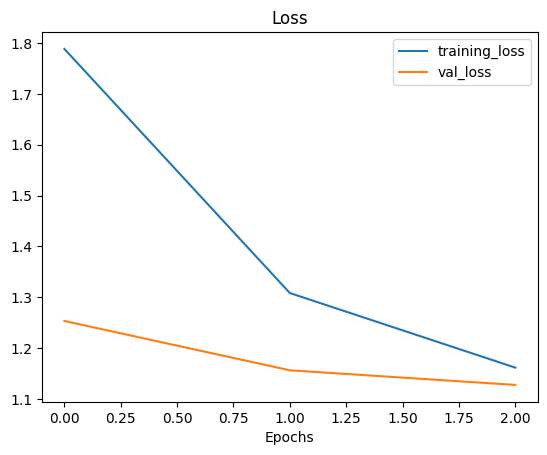

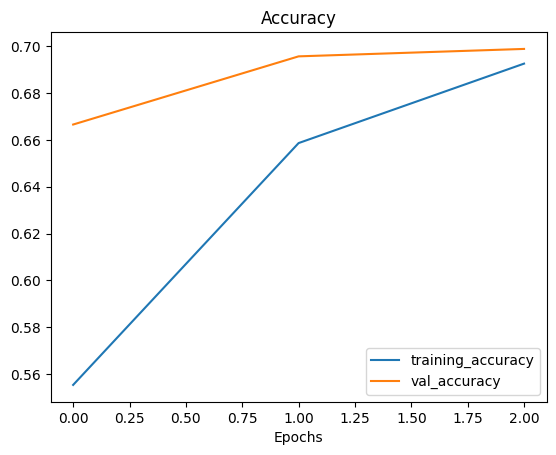

In [30]:
# Check loss curves
peebs_plot_loss_curves(history_food101_main)

* We can say that a little more training and it will converge

## Try saving the model and check if I'll have the same output after loading

In [31]:
# Save the model locally (but if you're using Colab, your saved model will also be deleted when the instance terminates)
save_dir="food101_efficientnetb4_model"
model.save(save_dir)

In [32]:
# HAHAHA I'm going to load the model now
loaded_saved_model = tf.keras.models.load_model(save_dir)

In [33]:
# Check the layers in the base model and check the dtype policy
for layer in loaded_saved_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) 

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "float32">
normalization False float32 <Policy "float32">
tf.math.truediv False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "float32">
stem_conv False float32 <Policy "float32">
stem_bn False float32 <Policy "float32">
stem_activation False float32 <Policy "float32">
block1a_dwconv False float32 <Policy "float32">
block1a_bn False float32 <Policy "float32">
block1a_activation False float32 <Policy "float32">
block1a_se_squeeze False float32 <Policy "float32">
block1a_se_reshape False float32 <Policy "float32">
block1a_se_reduce False float32 <Policy "float32">
block1a_se_expand False float32 <Policy "float32">
block1a_se_excite False float32 <Policy "float32">
block1a_project_conv False float32 <Policy "float32">
block1a_project_bn False float32 <Policy "float32">
block1b_dwconv False float32 <Policy "float32">
block1b_bn False float32 <Policy "float32">


In [34]:
# Check the model perfomance (this should now be the same)
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)

790/790 [==============================] - 121s 147ms/step - loss: 1.1208 - accuracy: 0.6972


In [35]:
# Check if the same
import numpy as np
assert np.isclose(results_whole_food_101_model, results_loaded_saved_model).all()

## I'm going to fine tune now
* This should make the accuracy go higher 

In [36]:
# Check the loaded_saved_model
loaded_saved_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, None, None, 1792)  17673823 
                                                                 
 pooling_layer (GlobalAverag  (None, 1792)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               181093    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 17,854,916
Trainable params: 181,093
Non-traina

In [37]:
for layer in loaded_saved_model.layers:
    layer.trainable = True # set all layers to trainable
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb4 True float32 <Policy "float32">
pooling_layer True float32 <Policy "float32">
dense True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">


In [38]:
# Check if the layers are now tranable
for layer in loaded_saved_model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "float32">
normalization True float32 <Policy "float32">
tf.math.truediv True float32 <Policy "float32">
stem_conv_pad True float32 <Policy "float32">
stem_conv True float32 <Policy "float32">
stem_bn True float32 <Policy "float32">
stem_activation True float32 <Policy "float32">
block1a_dwconv True float32 <Policy "float32">
block1a_bn True float32 <Policy "float32">
block1a_activation True float32 <Policy "float32">
block1a_se_squeeze True float32 <Policy "float32">
block1a_se_reshape True float32 <Policy "float32">
block1a_se_reduce True float32 <Policy "float32">
block1a_se_expand True float32 <Policy "float32">
block1a_se_excite True float32 <Policy "float32">
block1a_project_conv True float32 <Policy "float32">
block1a_project_bn True float32 <Policy "float32">
block1b_dwconv True float32 <Policy "float32">
block1b_bn True float32 <Policy "float32">


In [39]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [40]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [41]:
# Compile the model
loaded_saved_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [42]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune = loaded_saved_model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[peebs_tensorboard_callbacks("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20230410-125905
Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 0.8911 - accuracy: 0.7585

2368/2368 [==============================] - 2006s 836ms/step - loss: 0.8911 - accuracy: 0.7585 - val_loss: 0.7064 - val_accuracy: 0.8022 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 1883s 794ms/step - loss: 0.3692 - accuracy: 0.8961 - val_loss: 0.7328 - val_accuracy: 0.8069 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1297 - accuracy: 0.9606
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 1877s 792ms/step - loss: 0.1297 - accuracy: 0.9606 - val_loss: 0.8003 - val_accuracy: 0.8067 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 1893s 798ms/step - loss: 0.0214 - accuracy: 0.9948 - val_loss: 0.8628 - val_accuracy: 0.8366 - lr: 2.0000e-05


In [43]:
results_fine_tuned_saved_model = loaded_saved_model.evaluate(test_data)

790/790 [==============================] - 119s 151ms/step - loss: 0.8842 - accuracy: 0.8309


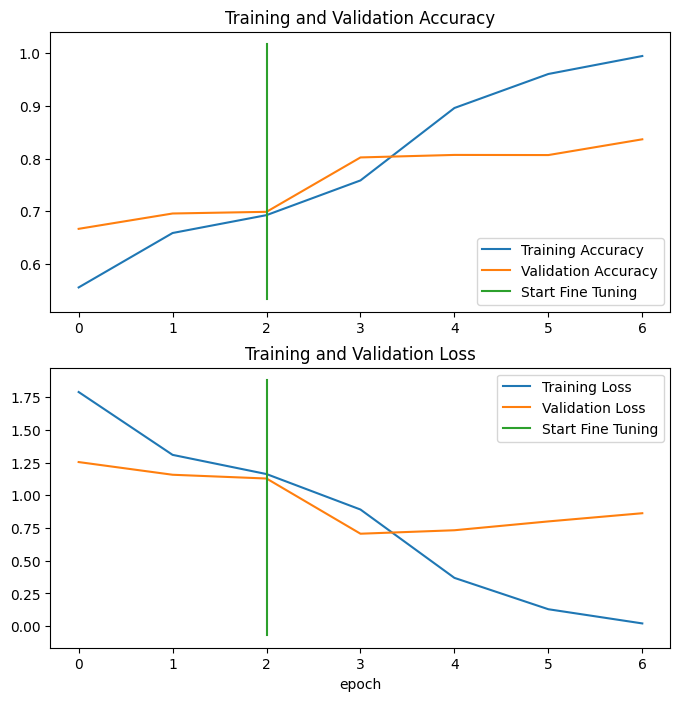

In [44]:
# Compare the two models
peebs_compare_historys(history_food101_main, history_101_food_classes_all_data_fine_tune, initial_epochs=3)

In [50]:
## View Training results in TensorBoard
# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime

# Upload experiment results to TensorBoard (uncomment to run)
!tensorboard dev upload --logdir ./training_logs \
--name "Fine-tuning EfficientNetB0 on all Food101 Data" \
--description "Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001" \
--one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./training_logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/usr/local/lib/python3.9/dist-packages/tensorboard/main.py", line 46, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "/usr/local/lib/python3.9/dist-packages/absl/app.py", line 308, in run
    _run_main(main, args)
  File "/usr/

In [46]:
# Save the new model
save_dir="food101_efficientnetb4_model_fine_tuned"
loaded_saved_model.save(save_dir)

In [49]:
# Pickle the model
import pickle
pickle.dump(loaded_saved_model, open('food101.pkl', 'wb'))
